In [1]:
import numpy as np

**Module** is an abstract class which defines fundamental methods necessary for a training a neural network. You do not need to change anything here, just read the comments.

In [2]:
class Module(object):
    """
    Basically, you can think of a module as of a something (black box)
    which can process `input` data and produce `ouput` data.
    This is like applying a function which is called `forward`:

        output = module.forward(input)

    The module should be able to perform a backward pass: to differentiate the `forward` function.
    More, it should be able to differentiate it if is a part of chain (chain rule).
    The latter implies there is a gradient from previous step of a chain rule.

        gradInput = module.backward(input, gradOutput)
    """
    def __init__ (self):
        self.output = None
        self.gradInput = None
        self.training = True

    def forward(self, input):
        """
        Takes an input object, and computes the corresponding output of the module.
        """
        return self.updateOutput(input)

    def backward(self,input, gradOutput):
        """
        Performs a backpropagation step through the module, with respect to the given input.

        This includes
         - computing a gradient w.r.t. `input` (is needed for further backprop),
         - computing a gradient w.r.t. parameters (to update parameters while optimizing).
        """
        self.updateGradInput(input, gradOutput)
        self.accGradParameters(input, gradOutput)
        return self.gradInput


    def updateOutput(self, input):
        """
        Computes the output using the current parameter set of the class and input.
        This function returns the result which is stored in the `output` field.

        Make sure to both store the data in `output` field and return it.
        """

        # The easiest case:

        # self.output = input
        # return self.output

        pass

    def updateGradInput(self, input, gradOutput):
        """
        Computing the gradient of the module with respect to its own input.
        This is returned in `gradInput`. Also, the `gradInput` state variable is updated accordingly.

        The shape of `gradInput` is always the same as the shape of `input`.

        Make sure to both store the gradients in `gradInput` field and return it.
        """

        # The easiest case:

        # self.gradInput = gradOutput
        # return self.gradInput

        pass

    def accGradParameters(self, input, gradOutput):
        """
        Computing the gradient of the module with respect to its own parameters.
        No need to override if module has no parameters (e.g. ReLU).
        """
        pass

    def zeroGradParameters(self):
        """
        Zeroes `gradParams` variable if the module has params.
        """
        pass

    def getParameters(self):
        """
        Returns a list with its parameters.
        If the module does not have parameters return empty list.
        """
        return []

    def getGradParameters(self):
        """
        Returns a list with gradients with respect to its parameters.
        If the module does not have parameters return empty list.
        """
        return []

    def train(self):
        """
        Sets training mode for the module.
        Training and testing behaviour differs for Dropout, BatchNorm.
        """
        self.training = True

    def evaluate(self):
        """
        Sets evaluation mode for the module.
        Training and testing behaviour differs for Dropout, BatchNorm.
        """
        self.training = False

    def __repr__(self):
        """
        Pretty printing. Should be overrided in every module if you want
        to have readable description.
        """
        return "Module"

# Sequential container

**Define** a forward and backward pass procedures.

In [3]:
class Sequential(Module):
    """
         This class implements a container, which processes `input` data sequentially.

         `input` is processed by each module (layer) in self.modules consecutively.
         The resulting array is called `output`.
    """

    def __init__ (self):
        super(Sequential, self).__init__()
        self.modules = []

    def add(self, module):
        """
        Adds a module to the container.
        """
        self.modules.append(module)

    def updateOutput(self, input):
        """
        Basic workflow of FORWARD PASS:

            y_0    = module[0].forward(input)
            y_1    = module[1].forward(y_0)
            ...
            output = module[n-1].forward(y_{n-2})


        Just write a little loop.
        """

        # Your code goes here. ################################################
        output = input
        for module in self.modules:
           output = module.forward(output)

        self.output = output
        return self.output

    def backward(self, input, gradOutput):
        """
        Workflow of BACKWARD PASS:

            g_{n-1} = module[n-1].backward(y_{n-2}, gradOutput)
            g_{n-2} = module[n-2].backward(y_{n-3}, g_{n-1})
            ...
            g_1 = module[1].backward(y_0, g_2)
            gradInput = module[0].backward(input, g_1)


        !!!

        To ech module you need to provide the input, module saw while forward pass,
        it is used while computing gradients.
        Make sure that the input for `i-th` layer the output of `module[i]` (just the same input as in forward pass)
        and NOT `input` to this Sequential module.

        !!!

        """
        # Your code goes here. ################################################
        grad = gradOutput

        for i in reversed(range(len(self.modules))):
           module = self.modules[i]
           if i == 0:
              grad = module.backward(input, grad)
           else:
              grad = module.backward(self.modules[i - 1].output, grad)

        self.gradInput = grad
        return self.gradInput


    def zeroGradParameters(self):
        for module in self.modules:
            module.zeroGradParameters()

    def getParameters(self):
        """
        Should gather all parameters in a list.
        """
        return [x.getParameters() for x in self.modules]

    def getGradParameters(self):
        """
        Should gather all gradients w.r.t parameters in a list.
        """
        return [x.getGradParameters() for x in self.modules]

    def __repr__(self):
        string = "".join([str(x) + '\n' for x in self.modules])
        return string

    def __getitem__(self,x):
        return self.modules.__getitem__(x)

    def train(self):
        """
        Propagates training parameter through all modules
        """
        self.training = True
        for module in self.modules:
            module.train()

    def evaluate(self):
        """
        Propagates training parameter through all modules
        """
        self.training = False
        for module in self.modules:
            module.evaluate()







# Layers

## 1 (0.2). Linear transform layer
Also known as dense layer, fully-connected layer, FC-layer, InnerProductLayer (in caffe), affine transform
- input:   **`batch_size x n_feats1`**
- output: **`batch_size x n_feats2`**

In [4]:
class Linear(Module):
    """
    A module which applies a linear transformation
    A common name is fully-connected layer, InnerProductLayer in caffe.

    The module should work with 2D input of shape (n_samples, n_feature).
    """
    def __init__(self, n_in, n_out):
        super(Linear, self).__init__()

        # This is a nice initialization
        stdv = 1./np.sqrt(n_in)
        self.W = np.random.uniform(-stdv, stdv, size = (n_out, n_in))
        self.b = np.random.uniform(-stdv, stdv, size = n_out)

        self.gradW = np.zeros_like(self.W)
        self.gradb = np.zeros_like(self.b)

    def updateOutput(self, input):
        # Your code goes here. ################################################
        self.output =np.dot(input, self.W.T)+self.b
        return self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        self.gradInput =  np.dot(gradOutput, self.W)
        return self.gradInput

    def accGradParameters(self, input, gradOutput):
        # Your code goes here. ################################################
        self.gradW = np.dot(gradOutput.T, input)
        self.gradb =np.sum(gradOutput, axis=0)
        pass


    def zeroGradParameters(self):
        self.gradW.fill(0)
        self.gradb.fill(0)

    def getParameters(self):
        return [self.W, self.b]

    def getGradParameters(self):
        return [self.gradW, self.gradb]

    def __repr__(self):
        s = self.W.shape
        q = 'Linear %d -> %d' %(s[1],s[0])
        return q

## 2. (0.2) SoftMax
- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

$\text{softmax}(x)_i = \frac{\exp x_i} {\sum_j \exp x_j}$

Recall that $\text{softmax}(x) == \text{softmax}(x - \text{const})$. It makes possible to avoid computing exp() from large argument.

In [5]:
class SoftMax(Module):
    def __init__(self):
         super(SoftMax, self).__init__()

    def updateOutput(self, input):
        # start with normalization for numerical stability
        self.output = np.subtract(input, input.max(axis=1, keepdims=True))
        # Your code goes here. ################################################
        exp=np.exp(self.output)
        sum=np.sum(exp, axis=1, keepdims=True)
        self.output=exp / sum
        return self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        self.output = self.updateOutput(input)

        sum= np.sum(gradOutput * self.output, axis=1, keepdims=True)

        self.gradInput = self.output * (gradOutput- sum)


        return self.gradInput

    def __repr__(self):
        return "SoftMax"

## 3. (0.2) LogSoftMax
- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

$\text{logsoftmax}(x)_i = \log\text{softmax}(x)_i = x_i - \log {\sum_j \exp x_j}$

The main goal of this layer is to be used in computation of log-likelihood loss.

In [ ]:
class LogSoftMax(Module):
    def __init__(self):
         super(LogSoftMax, self).__init__()

    def updateOutput(self, input):
        # start with normalization for numerical stability
        self.output = np.subtract(input, input.max(axis=1, keepdims=True))
        exp=np.exp(self.output)
        sum=np.sum(exp, axis=1, keepdims=True)
        self.output=self.output-np.log(sum)

        # Your code goes here. ################################################
        return self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        self.output = np.subtract(input, input.max(axis=1, keepdims=True))
        exp=np.exp(self.output)
        sum=np.sum(exp, axis=1, keepdims=True)
        self.output=exp / sum
        self.gradInput = gradOutput - self.output * np.sum(gradOutput, axis=1, keepdims=True)

        return self.gradInput

    def __repr__(self):
        return "LogSoftMax"

## 4. (0.3) Batch normalization
One of the most significant recent ideas that impacted NNs a lot is [**Batch normalization**](http://arxiv.org/abs/1502.03167). The idea is simple, yet effective: the features should be whitened ($mean = 0$, $std = 1$) all the way through NN. This improves the convergence for deep models letting it train them for days but not weeks. **You are** to implement the first part of the layer: features normalization. The second part (`ChannelwiseScaling` layer) is implemented below.

- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

The layer should work as follows. While training (`self.training == True`) it transforms input as $$y = \frac{x - \mu}  {\sqrt{\sigma + \epsilon}}$$
where $\mu$ and $\sigma$ - mean and variance of feature values in **batch** and $\epsilon$ is just a small number for numericall stability. Also during training, layer should maintain exponential moving average values for mean and variance:
```
    self.moving_mean = self.moving_mean * alpha + batch_mean * (1 - alpha)
    self.moving_variance = self.moving_variance * alpha + batch_variance * (1 - alpha)
```
During testing (`self.training == False`) the layer normalizes input using moving_mean and moving_variance.

Note that decomposition of batch normalization on normalization itself and channelwise scaling here is just a common **implementation** choice. In general "batch normalization" always assumes normalization + scaling.

In [6]:
class BatchNormalization(Module):
    EPS = 1e-3
    def __init__(self, alpha = 0.):
        super(BatchNormalization, self).__init__()
        self.alpha = alpha
        self.moving_mean = None
        self.moving_variance = None

    def updateOutput(self, input):
        # Your code goes here. ################################################
        # use self.EPS please
        if self.moving_mean is None:
            self.moving_mean = 0
        if self.moving_variance is None:
            self.moving_variance = 0

        if self.training == True:
          s=np.sum(input, axis=0, keepdims=True) # максимально подробно расписала как получить среднее и дисперсию
          self.batch_mean= s/input.shape[0]
          sq=(input-self.batch_mean)**2
          self.batch_variance= np.sum(sq, axis=0, keepdims=True)/ input.shape[0]
          self.output= (input-self.batch_mean)/ (self.batch_variance+self.EPS)**(1/2)
          self.moving_mean = self.alpha * self.moving_mean + (1 - self.alpha) * self.batch_mean
          self.moving_variance = self.alpha * self.moving_variance + (1 - self.alpha) * self.batch_variance
        else:
            self.output = (input - self.moving_mean)/ (self.moving_variance + self.EPS)**(1/2)

        return self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        var = np.sum(gradOutput * ((-1/2)* (input - self.batch_mean) * (self.batch_variance + self.EPS)**(-3/2)), axis=0)
        sum=np.sum( (-2)*(input - self.batch_mean) , axis=0, keepdims=True)/input.shape[0]
        mean_part=var * sum
        mean=np.sum(gradOutput * (-1/ (self.batch_variance + self.EPS)**(1/2)), axis=0)+mean_part
        self.gradInput= (gradOutput*((1/(self.batch_variance + self.EPS))**(1/2))) + (var*2*(input - self.batch_mean)/input.shape[0])+ (mean/input.shape[0])
        return self.gradInput

    def __repr__(self):
        return "BatchNormalization"

In [8]:
class ChannelwiseScaling(Module):
    """
       Implements linear transform of input y = \gamma * x + \beta
       where \gamma, \beta - learnable vectors of length x.shape[-1]
    """
    def __init__(self, n_out):
        super(ChannelwiseScaling, self).__init__()

        stdv = 1./np.sqrt(n_out)
        self.gamma = np.random.uniform(-stdv, stdv, size=n_out)
        self.beta = np.random.uniform(-stdv, stdv, size=n_out)

        self.gradGamma = np.zeros_like(self.gamma)
        self.gradBeta = np.zeros_like(self.beta)

    def updateOutput(self, input):
        self.output = input * self.gamma + self.beta
        return self.output

    def updateGradInput(self, input, gradOutput):
        self.gradInput = gradOutput * self.gamma
        return self.gradInput

    def accGradParameters(self, input, gradOutput):
        self.gradBeta = np.sum(gradOutput, axis=0)
        self.gradGamma = np.sum(gradOutput*input, axis=0)

    def zeroGradParameters(self):
        self.gradGamma.fill(0)
        self.gradBeta.fill(0)

    def getParameters(self):
        return [self.gamma, self.beta]

    def getGradParameters(self):
        return [self.gradGamma, self.gradBeta]

    def __repr__(self):
        return "ChannelwiseScaling"

Practical notes. If BatchNormalization is placed after a linear transformation layer (including dense layer, convolutions, channelwise scaling) that implements function like `y = weight * x + bias`, than bias adding become useless and could be omitted since its effect will be discarded while batch mean subtraction. If BatchNormalization (followed by `ChannelwiseScaling`) is placed before a layer that propagates scale (including ReLU, LeakyReLU) followed by any linear transformation layer than parameter `gamma` in `ChannelwiseScaling` could be freezed since it could be absorbed into the linear transformation layer.

## 5. (0.3) Dropout
Implement [**dropout**](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf). The idea and implementation is really simple: just multimply the input by $Bernoulli(p)$ mask. Here $p$ is probability of an element to be zeroed.

This has proven to be an effective technique for regularization and preventing the co-adaptation of neurons.

While training (`self.training == True`) it should sample a mask on each iteration (for every batch), zero out elements and multiply elements by $1 / (1 - p)$. The latter is needed for keeping mean values of features close to mean values which will be in test mode. When testing this module should implement identity transform i.e. `self.output = input`.

- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

In [7]:
class Dropout(Module):
    def __init__(self, p=0.5):
        super(Dropout, self).__init__()

        self.p = p
        self.mask = None

    def updateOutput(self, input):
        # Your code goes here. ################################################
          if self.training==True:
            size=input.shape
            self.mask = np.random.binomial(1, 1 - self.p, size=size)
            self.output = input * self.mask/(1 - self.p)
          else:
            self.output = input
          return  self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        self.gradInput=gradOutput* self.mask /(1 - self.p)
        return self.gradInput

    def __repr__(self):
        return "Dropout"

#6. (2.0) Conv2d
Implement [**Conv2d**](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html). Use only this list of parameters: (in_channels, out_channels, kernel_size, stride, padding, bias, padding_mode) and fix dilation=1 and groups=1.

код должен работать но я запуталась с весами









class Conv2d(Module):
    def __init__(self, in_channels, out_channels, kernel_size,
                 stride=1, padding=0, bias=True, padding_mode='zeros'):
        super(Conv2d, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.bias = bias
        self.padding_mode = padding_mode

    def updateOutput(self, input):
        # Your code goes here. ################################################
         if self.padding=="same":
             height=input.shape[2]
             width = input.shape[3]
            #  if height==width:
            #     if ((self.stride - 1) *height  + self.kernel_size - self.stride)% 2 != 0 :
            #        self.padding =(((self.stride - 1) *height  + self.kernel_size - self.stride) // 2)+1
            #  else:
             self.padding = ((self.stride - 1) *height  + self.kernel_size - self.stride) // 2

         if self.padding > 0:
            if self.padding_mode == 'zeros':
                input = np.pad(input, ((0, 0), (0, 0), (self.padding, self.padding), (self.padding, self.padding)), mode='constant')
            elif self.padding_mode == 'replicate':
                input = np.pad(input, ((0, 0), (0, 0), (self.padding, self.padding), (self.padding, self.padding)), mode='edge')
            elif self.padding_mode == 'reflect':
                input = np.pad(input, ((0, 0), (0, 0), (self.padding, self.padding), (self.padding, self.padding)), mode='reflect')

         batch_size=input.shape[0]
         in_channels=input.shape[1]
         height=input.shape[2]
         width = input.shape[3]

         if type(stride)==int:
            stride1=stride2=self.stride          
         else:
            stride1= self.stride[0]
            stride2= self.stride[1]

         h = 1+((height - self.kernel_size) // stride1)
         w = 1+((width - self.kernel_size ) // stride2)

         self.output = np.zeros((batch_size, self.out_channels, h, w))

         for bs in range(batch_size):
              for oc in range(self.out_channels):
                  for i in range(h):
                    for j in range(w):
                        h1 = i * stride1
                        h2 = h1 + self.kernel_size
                        w1 = j * stride2
                        w2 = w1 + self.kernel_size
                        kernel = input[bs, : , h1:h2, w1:w2]
                        self.output[bs, oc, i, j] = np.sum(kernel * self.custom_layer.weight[oc]) #код должен работать но я запуталась откуда брать веса
                        if self.bias==True:
                            self.output[bs, oc, i, j]=self.output[bs, oc, i, j]+ self.custom_layer.bias[oc]
         return  self.output


In [26]:
# class Conv2d(Module):
#     def __init__(self, in_channels, out_channels, kernel_size,
#                  stride=1, padding=0, bias=True, padding_mode='zeros'):
#         super(Conv2d, self).__init__()

#         self.in_channels = in_channels
#         self.out_channels = out_channels
#         self.kernel_size = kernel_size
#         self.stride = stride
#         self.padding = padding
#         self.bias = bias
#         self.padding_mode = padding_mode

#     def updateOutput(self, input):
#         # Your code goes here. ################################################
#          if self.padding=="same":
#              height=input.shape[2]
#              width = input.shape[3]
#             #  if height==width:
#             #     if ((self.stride - 1) *height  + self.kernel_size - self.stride)% 2 != 0 :
#             #        self.padding =(((self.stride - 1) *height  + self.kernel_size - self.stride) // 2)+1
#             #  else:
#              self.padding = ((self.stride - 1) *height  + self.kernel_size - self.stride) // 2

#          if self.padding > 0:
#             if self.padding_mode == 'zeros':
#                 input = np.pad(input, ((0, 0), (0, 0), (self.padding, self.padding), (self.padding, self.padding)), mode='constant')
#             elif self.padding_mode == 'replicate':
#                 input = np.pad(input, ((0, 0), (0, 0), (self.padding, self.padding), (self.padding, self.padding)), mode='edge')
#             elif self.padding_mode == 'reflect':
#                 input = np.pad(input, ((0, 0), (0, 0), (self.padding, self.padding), (self.padding, self.padding)), mode='reflect')

#          batch_size=input.shape[0]
#          in_channels=input.shape[1]
#          height=input.shape[2]
#          width = input.shape[3]

#          if type(stride)==int:
#             stride1=stride2=self.stride
#          else:
#             stride1= self.stride[0]
#             stride2= self.stride[1]

#          h = 1+((height - self.kernel_size) // stride1)
#          w = 1+((width - self.kernel_size ) // stride2)

#          self.output = np.zeros((batch_size, self.out_channels, h, w))

#          for bs in range(batch_size):
#               for oc in range(self.out_channels):
#                   for i in range(h):
#                     for j in range(w):
#                         h1 = i * stride1
#                         h2 = h1 + self.kernel_size
#                         w1 = j * stride2
#                         w2 = w1 + self.kernel_size
#                         kernel = input[bs, : , h1:h2, w1:w2]
#                         self.output[bs, oc, i, j] = np.sum(kernel * self.custom_layer.weight[oc]) #код должен работать но я запуталась откуда брать веса
#                         if self.bias==True:
#                             self.output[bs, oc, i, j]=self.output[bs, oc, i, j]+ self.custom_layer.bias[oc]
#          return  self.output

    # def updateGradInput(self, input, gradOutput):
    #     # Your code goes here. ################################################
    #     return self.gradInput

    # def __repr__(self):
    #     return "Conv2d"

# hyperparams = [
#     # {'batch_size': 8, 'in_channels': 3, 'out_channels': 6, 'height': 32, 'width': 32,
#     # 'kernel_size': 3, 'stride': 1, 'padding': 1, 'bias': True, 'padding_mode': 'zeros'},
#     # {'batch_size': 4, 'in_channels': 1, 'out_channels': 2, 'height': 28, 'width': 28,
#     # 'kernel_size': 5, 'stride': 2, 'padding': 2, 'bias': False, 'padding_mode': 'replicate'},
#     # {'batch_size': 16, 'in_channels': 3, 'out_channels': 3, 'height': 64, 'width': 64,
#     # 'kernel_size': 3, 'stride': 1, 'padding': 'same', 'bias': True, 'padding_mode': 'reflect'},
#     {'batch_size': 2, 'in_channels': 3, 'out_channels': 8, 'height': 10, 'width': 10,
#     'kernel_size': 2, 'stride': (1,2), 'padding': 0, 'bias': True, 'padding_mode': 'zeros'},
# ]


# for _ in range(1):
#    for params in hyperparams:
#     batch_size = params['batch_size']
#     print(batch_size)
#     in_channels = params['in_channels']
#     out_channels = params['out_channels']
#     height = params['height']
#     print(height)
#     width = params['width']
#     print(width)
#     kernel_size = params['kernel_size']
#     stride = params['stride']
#     padding = params['padding']
#     bias = params['bias']
#     padding_mode = params['padding_mode']
#     custom_layer = Conv2d(in_channels, out_channels, kernel_size,
#                                 stride=stride, padding=padding, bias=bias,
#                                 padding_mode=padding_mode)
#     custom_layer.train()

#     torch_layer = torch.nn.Conv2d(in_channels, out_channels, kernel_size,
#                                   stride=stride, padding=padding, bias=bias,
#                                   padding_mode=padding_mode)
#     print(torch_layer)

#     custom_layer.weight = torch_layer.weight.detach().numpy().copy()
#     print(custom_layer.weight)
#     if bias:
#         custom_layer.bias = torch_layer.bias.detach().numpy().copy()

#     layer_input = np.random.randn(batch_size, in_channels, height, width).astype(np.float32)
#     input_var = torch.tensor(layer_input, requires_grad=True)
#     print(input_var)

#     custom_output = custom_layer.updateOutput(layer_input)
#     print(custom_output)
#     torch_output = torch_layer(input_var)
#     print(torch_output)
#     assert(
#         np.allclose(torch_output.detach().numpy(), custom_output, atol=1e-6))

#           # next_layer_grad = np.random.randn(*torch_output.shape).astype(np.float32)
#           # custom_grad = custom_layer.updateGradInput(layer_input, next_layer_grad)
#           # torch_output.backward(torch.tensor(next_layer_grad))
#           # torch_grad = input_var.grad.detach().numpy()
#           # self.assertTrue(
#           #     np.allclose(torch_grad, custom_grad, atol=1e-5))

#7. (0.5) Implement [**MaxPool2d**](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) and [**AvgPool2d**](https://pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html). Use only parameters like kernel_size, stride, padding (negative infinity for maxpool and zero for avgpool) and other parameters fixed as in framework.

In [27]:
class MaxPool2d(Module):
    def __init__(self, kernel_size, stride, padding):
        super(MaxPool2d, self).__init__()

        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

    def updateOutput(self, input):

        if self.padding > 0:
           input = np.pad(array=input,
                          pad_width=((0, 0), (0, 0), (self.padding, self.padding), (self.padding, self.padding)),
                          mode='constant',
                          constant_values=-np.inf )

        batch_size = input.shape[0]
        channels = input.shape[1]
        height = input.shape[2]
        width = input.shape[3]

        if type(stride)==int:
            stride1=stride2=self.stride
        else:
            stride1= self.stride[0]
            stride2= self.stride[1]

        h = 1 + (height - self.kernel_size) // self.stride
        w = 1 + (width - self.kernel_size) // self.stride
        self.output = np.zeros((batch_size, channels, h, w))
        self.ind = np.zeros((batch_size, channels, h, w, 2), dtype=int)

        for bs in range(batch_size):
            for c in range(channels):
                for i in range(h):
                    for j in range(w):
                        hs = i * self.stride
                        he = hs + self.kernel_size
                        ws = j * self.stride
                        we = ws + self.kernel_size
                        kernel = input[bs, c, hs:he, ws:we]
                        self.output[bs, c, i, j] = np.max(kernel)
                        unr = np.argmax(kernel)
                        unr_2d = (unr // kernel_size, unr % kernel_size)
                        original_index = (hs + unr_2d[0]-self.padding, ws + unr_2d[1]-self.padding)
                        self.ind[bs, c, i, j] = original_index

        return self.output

    def updateGradInput(self, input, gradOutput):

        batch_size = input.shape[0]
        channels = input.shape[1]
        height = input.shape[2]
        width = input.shape[3]
        self.gradInput = np.zeros_like(input)


        h = 1 + ((height - self.kernel_size+2*self.padding) // self.stride)
        w = 1 + ((width - self.kernel_size+2*self.padding) // self.stride)

        for bs in range(batch_size):
            for c in range(channels):
                for i in range(h):
                    for j in range(w):
                        mx = self.ind[bs, c, i, j]
                        self.gradInput[bs, c, mx[0], mx[1]] = self.gradInput[bs, c, mx[0], mx[1]]  + gradOutput[bs, c, i, j]

        return self.gradInput

    def __repr__(self):
        return "MaxPool2d"




In [ ]:
class MaxPool2d(Module):
    def __init__(self, kernel_size, stride, padding):
        super(MaxPool2d, self).__init__()

        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

    def updateOutput(self, input):

        if self.padding > 0:
           input = np.pad(array=input,
                          pad_width=((0, 0), (0, 0), (self.padding, self.padding), (self.padding, self.padding)),
                          mode='constant',
                          constant_values=-np.inf)

        batch_size = input.shape[0]
        channels = input.shape[1]
        height = input.shape[2]
        width = input.shape[3]


        h = 1 + (height - self.kernel_size) // self.stride
        w = 1 + (width - self.kernel_size) // self.stride
        self.output = np.zeros((batch_size, channels, h, w))
        self.ind = np.zeros((batch_size, channels, h, w, 2), dtype=int)

        for bs in range(batch_size):
            for c in range(channels):
                for i in range(h):
                    for j in range(w):
                        hs = i * self.stride
                        he = hs + self.kernel_size
                        ws = j * self.stride
                        we = ws + self.kernel_size
                        kernel = input[bs, c, hs:he, ws:we]
                        self.output[bs, c, i, j] = np.max(kernel)
                        unr = np.unravel_index(np.argmax(kernel), kernel.shape)
                        self.ind[bs, c, i, j] = (unr[0] + hs, unr[1] + ws)

        return self.output

    def updateGradInput(self, input, gradOutput):

        batch_size = input.shape[0]
        channels = input.shape[1]
        height = input.shape[2]
        width = input.shape[3]
        self.gradInput = np.zeros_like(input)

        h = 1 + ((height - self.kernel_size) // self.stride)
        w = 1 + ((width - self.kernel_size) // self.stride)

        for bs in range(batch_size):
            for c in range(channels):
                for i in range(h):
                    for j in range(w):
                        mx = self.ind[bs, c, i, j]
                        self.gradInput[bs, c, mx[0], mx[1]] = self.gradInput[bs, c, mx[0], mx[1]] + gradOutput[bs, c, i, j]

        return self.gradInput

    def __repr__(self):
        return "MaxPool2d"

class AvgPool2d(Module):
    def __init__(self, kernel_size, stride, padding):

        super(AvgPool2d, self).__init__()

        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

    def updateOutput(self, input):
        # Your code goes here. ################################################
        if self.padding > 0:
           input = np.pad(array=input,
                          pad_width=((0, 0), (0, 0), (self.padding, self.padding), (self.padding, self.padding)),
                          mode='constant')

        batch_size = input.shape[0]
        channels = input.shape[1]
        height = input.shape[2]
        width = input.shape[3]

        h = 1 + (height - self.kernel_size) // self.stride
        w = 1 + (width- self.kernel_size) // self.stride
        self.output = np.zeros((batch_size, channels, h, w))
        self.ind = np.zeros((batch_size, channels, h, w, 2), dtype=int)

        for bs in range(batch_size):
            for c in range(channels):
                for i in range(h):
                    for j in range(w):
                        hs = i * self.stride
                        he = hs + self.kernel_size
                        ws = j * self.stride
                        we = ws + self.kernel_size
                        kernel = input[bs, c, hs:he, ws:we]
                        self.output[bs, c, i, j] = np.mean(kernel)
                        unr = np.argmax(kernel)
                        unr_2d = (unr // self.kernel_size, unr % self.kernel_size)
                        original_index = (hs + unr_2d[0]-self.padding, ws + unr_2d[1]-self.padding)
                        self.ind[bs, c, i, j] = original_index

        return  self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        batch_size = input.shape[0]
        channels = input.shape[1]
        height = input.shape[2]
        width = input.shape[3]
        self.gradInput = np.zeros_like(input)

        h = 1 + ((height - self.kernel_size+2*self.padding) // self.stride)
        w = 1 + ((width - self.kernel_size+2*self.padding) // self.stride)

        for bs in range(batch_size):
            for c in range(channels):
                for i in range(h):
                    for j in range(w):
                        mx = self.ind[bs, c, i, j]
                        self.gradInput[bs, c, mx[0], mx[1]] = self.gradInput[bs, c, mx[0], mx[1]] + gradOutput[bs, c, i, j]
        return self.gradInput

    def __repr__(self):
        return "AvgPool2d"

#8. (0.3) Implement **GlobalMaxPool2d** and **GlobalAvgPool2d**. They do not have testing and parameters are up to you but they must aggregate information within channels. Write test functions for these layers on your own.

#9. (0.2) Implement [**Flatten**](https://pytorch.org/docs/stable/generated/torch.flatten.html)

In [ ]:

class Flatten(Module):
    def __init__(self, start_dim=0, end_dim=-1):
        super(Flatten, self).__init__()

        self.start_dim = start_dim
        self.end_dim = end_dim

    def updateOutput(self, input):
        # Your code goes here. ################################################
        if self.end_dim == -1:
            self.end_dim = input.ndim - 1

        flatten1 = input.shape[:self.start_dim]
        flatten2 = input.shape[self.end_dim + 1:]
        self.shape = flatten1 + (-1,) + flatten2
        self.output = input.reshape(self.shape)

        return  self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        self.gradInput = gradOutput.reshape(input.shape)

        return self.gradInput

    def __repr__(self):
        return "Flatten"

# Activation functions

Here's the complete example for the **Rectified Linear Unit** non-linearity (aka **ReLU**):

In [8]:
class ReLU(Module):
    def __init__(self):
         super(ReLU, self).__init__()

    def updateOutput(self, input):
        self.output = np.maximum(input, 0)
        return self.output

    def updateGradInput(self, input, gradOutput):
        self.gradInput = np.multiply(gradOutput , input > 0)
        return self.gradInput

    def __repr__(self):
        return "ReLU"

## 10. (0.1) Leaky ReLU
Implement [**Leaky Rectified Linear Unit**](http://en.wikipedia.org/wiki%2FRectifier_%28neural_networks%29%23Leaky_ReLUs). Expriment with slope.

In [ ]:
class LeakyReLU(Module):
    def __init__(self, slope = 0.03):
        super(LeakyReLU, self).__init__()

        self.slope = slope

    def updateOutput(self, input):
        # Your code goes here. ################################################
        self.output = np.where(input <= 0, input * self.slope, input)
        return  self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        self.gradInput=np.where(input <= 0, gradOutput * self.slope, gradOutput)
        return self.gradInput

    def __repr__(self):
        return "LeakyReLU"

## 11. (0.1) ELU
Implement [**Exponential Linear Units**](http://arxiv.org/abs/1511.07289) activations.

In [ ]:
class ELU(Module):
    def __init__(self, alpha = 1.0):
        super(ELU, self).__init__()

        self.alpha = alpha

    def updateOutput(self, input):
        # Your code goes here. ################################################
        self.output = np.where(input <= 0, self.alpha * (np.exp(input) - 1), input)
        return  self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        self.gradInput = np.where(input <= 0, gradOutput * (self.alpha * np.exp(input)), gradOutput)
        return self.gradInput

    def __repr__(self):
        return "ELU"

## 12. (0.1) SoftPlus
Implement [**SoftPlus**](https://en.wikipedia.org/wiki%2FRectifier_%28neural_networks%29) activations. Look, how they look a lot like ReLU.

In [ ]:
class SoftPlus(Module):
    def __init__(self):
        super(SoftPlus, self).__init__()

    def updateOutput(self, input):
        # Your code goes here. ################################################
        self.output = np.log1p(np.exp(input))
        return  self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        self.gradInput = gradOutput * (1 / (1 + np.exp(-input)))
        return self.gradInput

    def __repr__(self):
        return "SoftPlus"

#13. (0.2) Gelu
Implement [**Gelu**](https://pytorch.org/docs/stable/generated/torch.nn.GELU.html) activations.

In [ ]:
from scipy.special import erf
class Gelu(Module):
    def __init__(self):
        super(Gelu, self).__init__()

    def updateOutput(self, input):
        # Your code goes here. ################################################
        self.func= (1/2) * (1 + erf(input / np.sqrt(2)))
        self.output = input * self.func
        return  self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        grad= (1 / (2 * np.pi)**(1/2)) * np.exp((-1/2) * input**2)
        self.gradInput = (gradOutput * self.func) + (gradOutput * input * grad)
        return self.gradInput

    def __repr__(self):
        return "Gelu"

# Criterions

Criterions are used to score the models answers.

In [9]:
class Criterion(object):
    def __init__ (self):
        self.output = None
        self.gradInput = None

    def forward(self, input, target):
        """
            Given an input and a target, compute the loss function
            associated to the criterion and return the result.

            For consistency this function should not be overrided,
            all the code goes in `updateOutput`.
        """
        return self.updateOutput(input, target)

    def backward(self, input, target):
        """
            Given an input and a target, compute the gradients of the loss function
            associated to the criterion and return the result.

            For consistency this function should not be overrided,
            all the code goes in `updateGradInput`.
        """
        return self.updateGradInput(input, target)

    def updateOutput(self, input, target):
        """
        Function to override.
        """
        return self.output

    def updateGradInput(self, input, target):
        """
        Function to override.
        """
        return self.gradInput

    def __repr__(self):
        """
        Pretty printing. Should be overrided in every module if you want
        to have readable description.
        """
        return "Criterion"

The **MSECriterion**, which is basic L2 norm usually used for regression, is implemented here for you.
- input:   **`batch_size x n_feats`**
- target: **`batch_size x n_feats`**
- output: **scalar**

In [10]:
class MSECriterion(Criterion):
    def __init__(self):
        super(MSECriterion, self).__init__()

    def updateOutput(self, input, target):
        self.output = np.sum(np.power(input - target,2)) / input.shape[0]
        return self.output

    def updateGradInput(self, input, target):
        self.gradInput  = (input - target) * 2 / input.shape[0]
        return self.gradInput

    def __repr__(self):
        return "MSECriterion"

## 14. (0.2) Negative LogLikelihood criterion (numerically unstable)
You task is to implement the **ClassNLLCriterion**. It should implement [multiclass log loss](http://scikit-learn.org/stable/modules/model_evaluation.html#log-loss). Nevertheless there is a sum over `y` (target) in that formula,
remember that targets are one-hot encoded. This fact simplifies the computations a lot. Note, that criterions are the only places, where you divide by batch size. Also there is a small hack with adding small number to probabilities to avoid computing log(0).
- input:   **`batch_size x n_feats`** - probabilities
- target: **`batch_size x n_feats`** - one-hot representation of ground truth
- output: **scalar**



In [ ]:
class ClassNLLCriterionUnstable(Criterion):
    EPS = 1e-15
    def __init__(self):
        a = super(ClassNLLCriterionUnstable, self)
        super(ClassNLLCriterionUnstable, self).__init__()

    def updateOutput(self, input, target):
        input_clamp = np.clip(input, self.EPS, 1 - self.EPS)
        # Your code goes here. ################################################
        self.output = (-1/ input.shape[0]) * np.sum(np.log(input_clamp)* target)
        return self.output

    def updateGradInput(self, input, target):

        # Use this trick to avoid numerical errors
        input_clamp = np.clip(input, self.EPS, 1 - self.EPS)

        # Your code goes here. ################################################
        self.gradInput = (-1/input.shape[0])*target*(1/ input_clamp)
        return self.gradInput

    def __repr__(self):
        return "ClassNLLCriterionUnstable"

## 15. (0.3) Negative LogLikelihood criterion (numerically stable)
- input:   **`batch_size x n_feats`** - log probabilities
- target: **`batch_size x n_feats`** - one-hot representation of ground truth
- output: **scalar**

Task is similar to the previous one, but now the criterion input is the output of log-softmax layer. This decomposition allows us to avoid problems with computation of forward and backward of log().

In [ ]:
class ClassNLLCriterion(Criterion):
    def __init__(self):
        a = super(ClassNLLCriterion, self)
        super(ClassNLLCriterion, self).__init__()

    def updateOutput(self, input, target):
        # Your code goes here. ################################################
        self.output = (-1/input.shape[0])*np.sum(target * input)
        return self.output

    def updateGradInput(self, input, target):
        # Your code goes here. ################################################
        self.gradInput=-target/input.shape[0]
        return self.gradInput

    def __repr__(self):
        return "ClassNLLCriterion"

1-я часть задания: реализация слоев, лосей и функций активации - 5 баллов. \\
2-я часть задания: реализация моделей на своих классах. Что должно быть:
  1. Выберите оптимизатор и реализуйте его, чтоб он работал с вами классами. - 1 балл.
  2. Модель для задачи мультирегрессии на выбраных вами данных. Использовать FCNN, dropout, batchnorm, MSE. Пробуйте различные фукнции активации. Для первой модели попробуйте большую, среднюю и маленькую модель. - 1 балл.
  3. Модель для задачи мультиклассификации на MNIST. Использовать свёртки, макспулы, флэттэны, софтмаксы - 1 балла.
  4. Автоэнкодер для выбранных вами данных. Должен быть на свёртках и полносвязных слоях, дропаутах, батчнормах и тд. - 2 балла. \\

Дополнительно в оценке каждой модели будет учитываться:
1. Наличие правильно выбранной метрики и лосс функции.
2. Отрисовка графиков лосей и метрик на трейне-валидации. Проверка качества модели на тесте.
3. Наличие шедулера для lr.
4. Наличие вормапа.
5. Наличие механизма ранней остановки и сохранение лучшей модели.
6. Свитч лося (метрики) и оптимайзера.

2 часть

In [11]:
class SGD:
    def __init__(self, parameters, learning_rate=0.05):
        self.parameters = parameters
        self.learning_rate = learning_rate

    def step(self, grad):
        for parameter, grad in zip(self.parameters, grad):
            parameter =parameter- (self.learning_rate * grad)

In [12]:
class Adam:
    def __init__(self, parameters, learning_rate=0.05, beta1=0.9, beta2=0.999, eps=1e-6):
        self.parameters = parameters
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps

        self.m0 = []
        self.v0 = []
        for parameter in parameters:
            self.m0.append(np.zeros_like(parameter))
            self.v0.append(np.zeros_like(parameter))
        self.teta0 = 0

    def step(self, grads):
        self.teta0 = self.teta0 +1
        for i, (parameter, grad) in enumerate(zip(self.parameters, grads)):
            self.m0[i] = self.beta1 * self.m0[i] + (1 - self.beta1) * grad
            self.v0[i] = self.beta2 * self.v0[i] + (1 - self.beta2) * (grad ** 2)

            m_kr = self.m0[i] / (1 - self.beta1 ** self.teta0)
            v_kr = self.v0[i] / (1 - self.beta2 ** self.teta0)

            parameter =  parameter - self.learning_rate * (m_kr / (((v_kr)**(1/2)) + self.eps))



    def zeroGradParameters(self):
         for parameter in self.parameters:
             parameter.fill(0)





<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

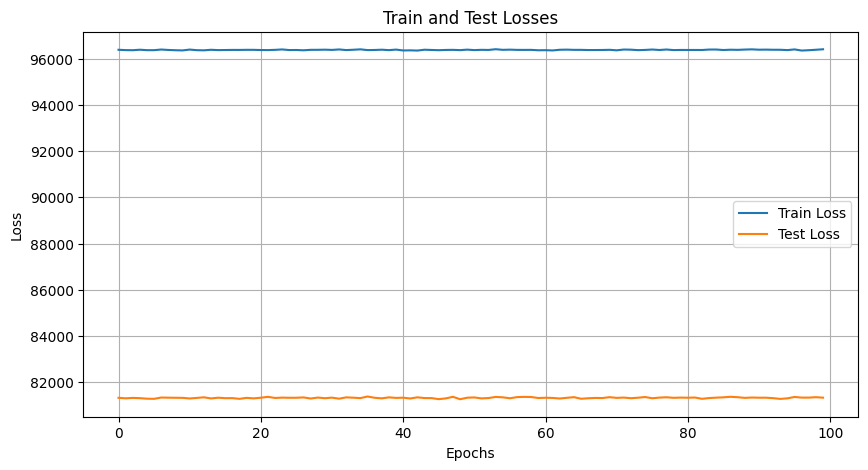

In [15]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X, y = make_regression(n_samples=1000, n_features=10, n_targets=3, noise=0.5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


class FCNN(Module):
    def __init__(self, input_size, output_size, hidden_layers):
        super(FCNN, self).__init__()
        self.layers = []
        self.layers.append(Linear(input_size, hidden_layers[0]))
        self.layers.append(BatchNormalization())
        self.layers.append(ReLU())
        self.layers.append(Dropout(p=0.5))
        for i in range(1, len(hidden_layers)):
            self.layers.append(Linear(hidden_layers[i-1], hidden_layers[i]))
            self.layers.append(BatchNormalization())
            self.layers.append(ReLU())
            self.layers.append(Dropout(p=0.5))
        self.layers.append(Linear(hidden_layers[-1], output_size))

    def updateOutput(self, input):
        for layer in self.layers:
            input = layer.forward(input)
        self.output = input
        return self.output

    def updateGradInput(self, input, gradOutput):
        for layer in reversed(self.layers):
            gradOutput = layer.backward(input, gradOutput)
            input = layer.output
        return gradOutput

def train_model(model, X_train, y_train, X_test, y_test, epochs=100, lr=0.1):
    criterion = MSECriterion()
    optimizer = Adam(model.getParameters(), learning_rate=lr)

    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        model.training = True
        model.getGradParameters()
        optimizer.zeroGradParameters()

        outputs = model.forward(X_train)
        loss = criterion.forward(outputs, y_train)
        train_losses.append(loss)
        model.backward(X_train, criterion.backward(outputs, y_train))
        grads = [layer.gradInput for layer in model.layers if hasattr(layer, 'gradInput')]
        optimizer.step(grads)
        model.training = False
        test_outputs = model.forward(X_test)
        test_loss = criterion.forward(test_outputs, y_test)
        test_losses.append(test_loss)

    return train_losses, test_losses


input_size = X_train.shape[1]
output_size = y_train.shape[1]
model = FCNN(input_size, output_size, [64, 32])

train_losses, test_losses = train_model(model, X_train, y_train, X_test, y_test)

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Train and Test Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt